In [336]:
from collections import Counter
import ast
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

plt.style.use('_mpl-gallery')
%matplotlib inline
pd.set_option('display.max_columns', None)

In [337]:
data_path = "./data/listings/"
data = pd.DataFrame()
for file_name in os.listdir(data_path):
    data = pd.concat([data, pd.read_csv(f"{data_path}{file_name}", sep=",")], ignore_index=True)

In [338]:
data.sort_values(by="last_scraped", ascending=False, inplace=True)
data.drop_duplicates(subset=["id"], keep="first", ignore_index=True, inplace=True)

In [351]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74859 entries, 0 to 74858
Columns: 286 entries, id to amenity_full kitchen
dtypes: bool(210), float64(19), int64(22), object(35)
memory usage: 58.4+ MB


In [339]:
def normalize_amenity(amenity: str) -> str:
    amenity = amenity.lower()
    amenity = amenity.replace("-", " ")
    amenity = re.sub(r"[^\w\s]", " ", amenity)
    amenity = re.sub(r"[\s]{2,}", " ", amenity)
    amenity = amenity.strip()
    return amenity

In [340]:
data["amenities"] = [[normalize_amenity(amenity) for amenity in ast.literal_eval(amenities)] for amenities in data["amenities"]]
# amenities = [normalize_amenity(amenity) for amenities in data["amenities"] for amenity in amenities]
# amenities = [amenity for amenities in data["amenities"] for amenity in amenities]
amenities = Counter(itertools.chain(*data["amenities"]))

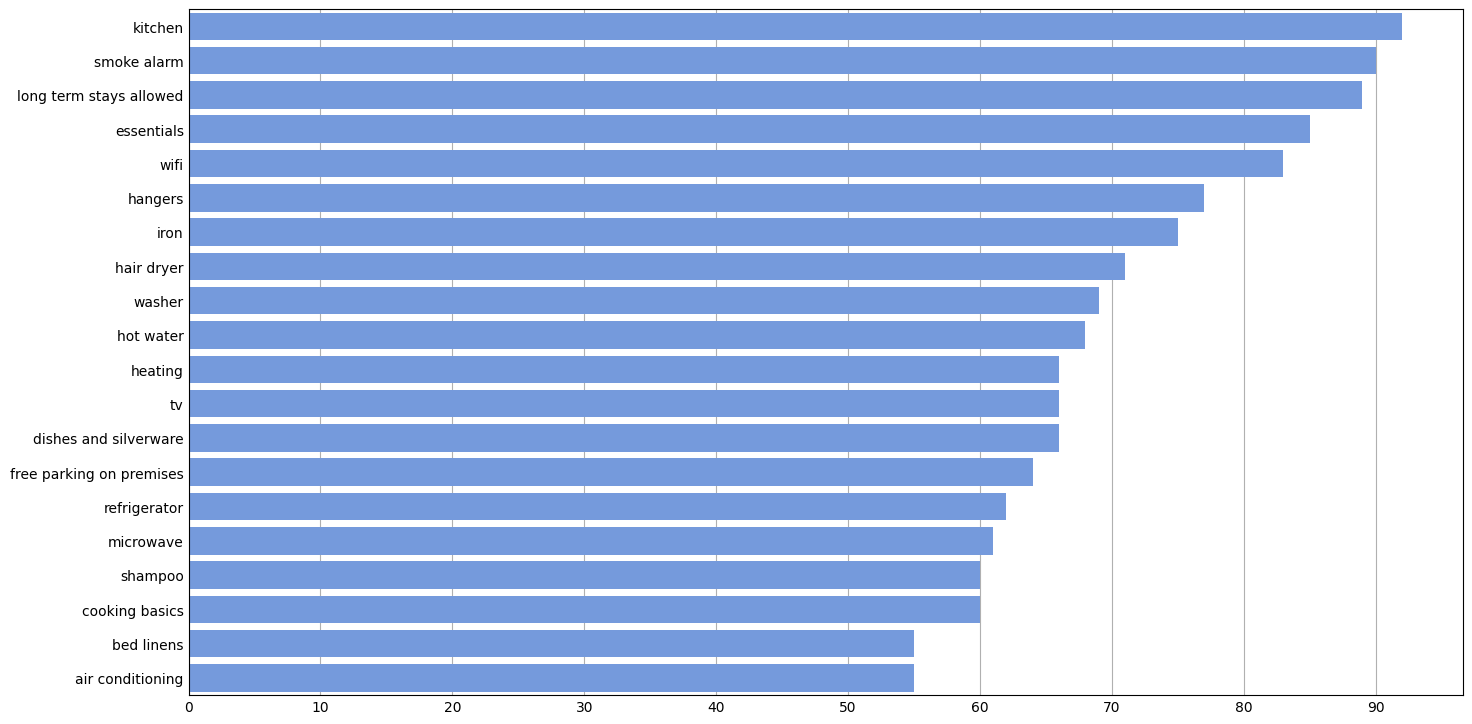

In [342]:
top20_amenities = dict(sorted(amenities.items(), key=lambda x:x[1], reverse=True)[:20])
top20_values_in_percent = [round(value / len(data) * 100) for value in top20_amenities.values()]

plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.barplot(x=top20_values_in_percent, y=list(top20_amenities.keys()), color = "cornflowerblue");

In [343]:
data["amenities_count"] = [len(amenities) for amenities in data["amenities"]]

In [ ]:
plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.pointplot(x=data["amenities_count"], y=data[""], color = "cornflowerblue");

In [350]:
# only use popular/standardized amenity values
MIN_AMENITY_COUNT = 200

origin_amenity_keys = len(amenities.keys())
origin_amenity_values_sum = sum(amenities.values())

amenities = {amenity: amenity_count for (amenity, amenity_count) in amenities.items() if amenity_count >= MIN_AMENITY_COUNT}

print(f"Removed {round(abs(len(amenities.keys()) / origin_amenity_keys - 1) * 100, 1)}% amenity keys "
      f"but only {round(abs(sum(amenities.values()) / origin_amenity_values_sum - 1) * 100, 1)}% of the set amenity values in total.")

Removed 0.0% amenity keys but only 0.0% of the set amenity values in total.


In [347]:
new_amenity_data = pd.concat([pd.Series(name=f"amenity_{amenity.replace("", "_")}",
                              data=[amenity in accomodation_amenities for accomodation_amenities in data["amenities"]]) 
                              for amenity in amenities.keys()], axis=1)
data = pd.concat([data, new_amenity_data], axis=1)